Computer: server
/experiment/export_data/data_play/ZKawakeM72_013_e_010_spikes.mat
/experiment/export_data/data_play/ZKawakeM72_013_f_010_spikes.mat
['ZKawakeM72_013_f_010', 'ZKawakeM72_013_e_010']
['/experiment/export_data/data_play/ZKawakeM72_013_f_trial.mat', '/experiment/export_data/data_play/ZKawakeM72_013_e_trial.mat']
/experiment/export_data/data_play/ZKawakeM72_013_f_trial.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_trial.mat
['/experiment/export_data/data_play/ZKawakeM72_013_f_noStimSniff.mat', '/experiment/export_data/data_play/ZKawakeM72_013_e_noStimSniff.mat']
/experiment/export_data/data_play/ZKawakeM72_013_f_noStimSniff.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_noStimSniff.mat
/experiment/export_data/data_play/ZKawakeM72_013_e_011_spikes.mat
['ZKawakeM72_013_e_011']
[]
[]


[{'ax_stack': <matplotlib.figure.AxesStack at 0x7f66e39cb410>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7f66e2b272d0>},
 {'ax_stack': <matplotlib.figure.AxesStack at 0x7f66e39c7850>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7f66e39124d0>},
 {'ax_stack': <matplotlib.figure.AxesStack at 0x7f66e3c0bf10>,
  'fig': None,
  'figure': <matplotlib.figure.Figure at 0x7f66e3e1e350>}]

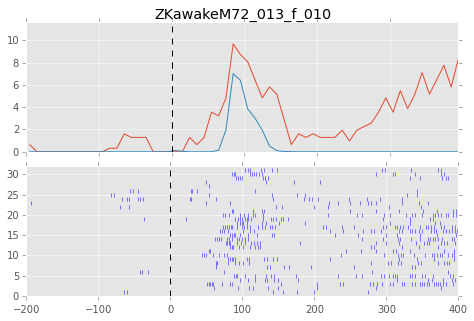

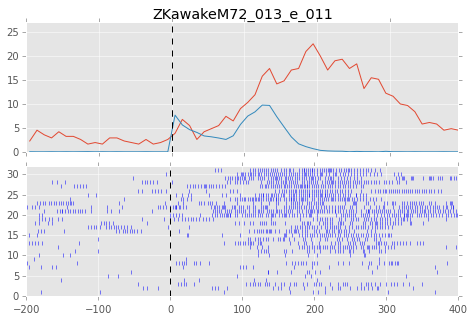

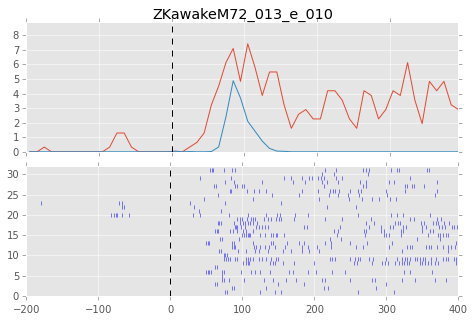

In [60]:
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os

matplotlib.style.use('ggplot')

comp_name=socket.gethostname()
if  comp_name == 'Ezequiels-MacBook-Pro.local':
    print 'Computer: ' + comp_name
    sys.path.append('/Users/zeke/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/Users','zeke','experiment')
else:
    print 'Computer: ' + 'server'
    sys.path.append('/experiment/ephysDataManagement/ephysScripts')
    experiment_folder = os.path.join('/','experiment')
    
import unitToolsv2
from data_handling import ephys_names as en
from data_handling.basic_plot import decim, plot_raster, make_psth
from data_handling import data_load as dl
from analysis import stimulus as st

#load all the records, to not load all the records for every stimulus
fn = en.file_names(root = experiment_folder)
cells_path = os.path.join(fn.fold_exp_data, 'data_play')
all_records = dl.load_cells(cells_path)

## create a stimulus and initialize it (load its responses)
high_2hydroxy = st.Odor(['2-hydroxyacetophenone','2hydroxyacetophenone'], 0.0051)
st_1 = st.Stimulus(high_2hydroxy, records = all_records, tags = {'light':1} )
#get the first response and plot it
[r.plot() for r in list(st_1.responses.values())]

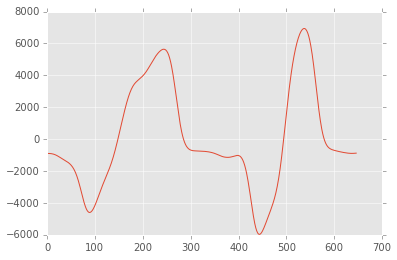

In [2]:
#just plot a sniff
plt.plot(all_records['base_sniff']['ZKawakeM72_013_f'][5]['flow'])

In [2]:
r0=st_1.responses['ZKawakeM72_013_e_010']
dir(st_1.responses['ZKawakeM72_013_e_010'])

['__doc__',
 '__init__',
 '__module__',
 'all_trials',
 'base_sniff',
 'baseline',
 'plot',
 'raster',
 'raster_plot',
 'rec']

In [29]:
print r0.raster.keys()
print r0.all_trials['ZKawakeM72_013_f_2766487'].keys()
trial['sniff_zero'][0]

['spikes', 'concs', 't_2', 'trialId', 't_0', 't_1', 'odors']
['start', 'sess', 'sniff_zero', 'sniff_flow', 'rec', 'mouse', 'odor', 'rec_id', 'odor_c', 'odor_t']


array([-5031, -4332, -3624, -2919, -2189, -1438,  -722,    -2,   728,
        1376,  2170,  2913,  3714,  4376,  5141,  5901])

ZKawakeM72_013_e_79690
['start', 'sess', 'sniff_zero', 'sniff_flow', 'rec', 'mouse', 'odor', 'rec_id', 'odor_c', 'odor_t']


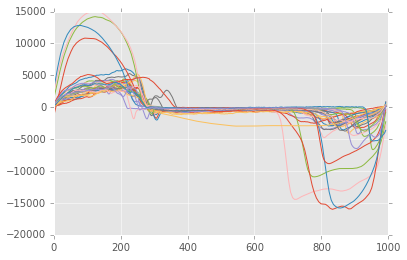

In [89]:
rec_name = 'ZKawakeM72_013_e_010'
all_spikes = all_records['responses'][rec_name]['all_spikes']
r0=st_1.responses[rec_name]
dir(st_1.responses[rec_name])

all_trial_id = r0.raster['trialId']
num_trials = len(all_trial_id)

ir = 0
print r0.raster['trialId'][ir]
tr_id = r0.raster['trialId'][ir]
trial = r0.all_trials[tr_id]

print trial.keys()
warped = True

if warped:
    inh_len, exh_len = get_warping_parameters(all_sniffs)
    t_post = inh_len + exh_len
    t_pre  = 0
else:   
    t_pre = -150
    t_post = 600

t_range = t_post - t_pre
raster = np.zeros((num_trials,t_range))
flows  = np.zeros((t_range, num_trials))

#quick raster
for ir in range(num_trials):
    # first inhale after odor onset (number relative to trial start)
    tr_id = r0.raster['trialId'][ir]
    trial = r0.all_trials[tr_id]
    trial_start = trial['start']
    stim_on = trial['odor_t'][0]
    condition_inh = (trial['sniff_zero'][0] > stim_on)
    inh_times = np.extract(condition_inh, trial['sniff_zero'][0])+200
    exh_times = np.extract(condition_inh, trial['sniff_zero'][1])+200
    
    if warped:
        t_inh = inh_times[0] + trial_start
        t_exh = exh_times[0] + trial_start
        t_end = inh_times[1] + trial_start
        inh = t_exh - t_inh
        exh = t_end - t_exh
        
        flows[0:inh_len,ir] = resize_chunk(-trial['sniff_flow'][inh_times[0]+t_pre:exh_times[0]+t_pre], inh_len)
        flows[inh_len: inh_len+exh_len,ir] = resize_chunk(-trial['sniff_flow'][exh_times[0]+t_pre:inh_times[1]+t_pre], exh_len)
    
    else:
        flows[:,ir] = -trial['sniff_flow'][inh_times[0]+t_pre:inh_times[0]+t_post]
        #flows[:,ir] = trial['sniff_flow'][0:t_range]
        #get absolute timestamps of spikes in the corresp. sniff segment
        t_inh = inh_times[0] + trial_start
        condition = (all_spikes > t_inh + t_pre) & (all_spikes < t_inh + t_post)
        spike_times = np.extract(condition, all_spikes) - t_inh - t_pre
        if spike_times.size>0 and inh_times[0]-stim_on > 50:
            raster[ir, spike_times] = 1

        
plt.plot((flows[0:t_post-t_pre,:]));
#plot_raster(raster, t0=-t_pre)
#plot_raster(raster, bin_size=15, t0=-t_pre)

In [17]:
spike_times

array([374, 378, 382, 385])

In [12]:
print stim_on
print inh_times
print exh_times

238
[ 447  926 1337 1675 2048 2384 2888 3325 3812 4248 4432 4773 5197 5655 5978]
[ 629 1001 1375 1715 2106 2470 2988 3466 3961 4296 4482 4894 5344 5809 6035]


(<matplotlib.collections.PathCollection at 0x7f66df98a750>,
 <matplotlib.axes._axes.Axes at 0x7f66dfa429d0>)

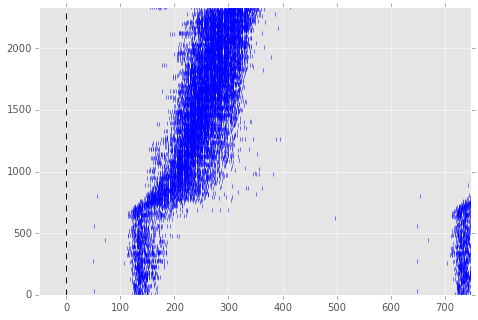

In [59]:
dir(r0.baseline)
plot_raster(r0.baseline.make_raster(t_post=800, warped=False),t0=50)

In [10]:
plt.plot(sniffs[10]['flow'])
sniffs[10]['t_zer_fit']
sniffs['t_zer_fit']

NameError: name 'sniffs' is not defined

In [9]:
sniff_data.keys()

['noStimSniffs', '__version__', '__header__', '__globals__']

In [20]:
sniffs = np.ndarray((10,), dtype=np.dtype([('flow', np.ndarray), ('t_zer_fit',np.zeros([1,1]))] ))

TypeError: data type not understood

In [31]:
arec = np.zeros((2,), dtype = np.dtype([('flow', np.ndarray), ('t_0',np.int)]))

In [43]:
arec[1]['flow']=np.array(50)

In [33]:
'ZKawakeM72_013_f_noStimSniff.mat'.split('_')[0:3]

['ZKawakeM72', '013', 'f']

In [48]:
sent_str = ""
for i in 'ZKawakeM72_013_f_noStimSniff.mat'.split('_')[0:3]:
    sent_str += str(i) + "_"
sent_str = sent_str[:-1]
print sent_str

ZKawakeM72_013_f


In [9]:
all_records['responses']['ZKawakeM72_013_e_010']['all_spikes']

array([    140,     144,     148, ..., 2853388, 2853391, 2853412])

In [17]:
mat_file_path='/Users/zeke/experiment/export_data/ZKawakeM72_013_e_011_spikes.mat'
assert(os.path.isfile(mat_file_path))
print (mat_file_path)
spike_data = sio.loadmat(mat_file_path, struct_as_record=False, squeeze_me=True)
spikes_loaded = spike_data['thisUnit']
all_spikes = np.array(spikes_loaded.times, dtype=np.float)

/Users/zeke/experiment/export_data/ZKawakeM72_013_e_011_spikes.mat


In [4]:
all_records['responses']['ZKawakeM72_013_e_010'].keys()

['all_spikes', 'meta', 'rec_id', 'odor_resp', 'light_resp']

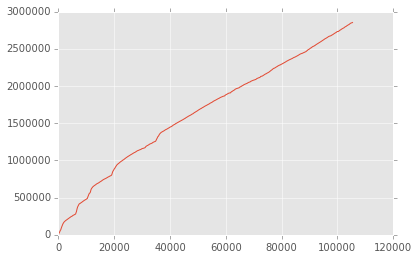

In [5]:
plt.plot(all_records['responses']['ZKawakeM72_013_e_011']['all_spikes'])

/experiment/export_data/ZKawakeM72_013_e_sniff.mat


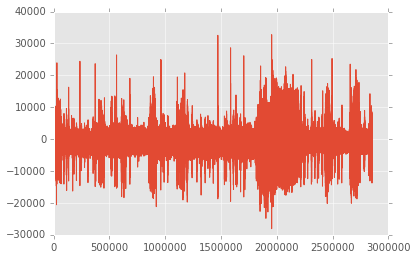

In [39]:
mat_file_path='/experiment/export_data/ZKawakeM72_013_e_sniff.mat'
assert(os.path.isfile(mat_file_path))
print (mat_file_path)
data = sio.loadmat(mat_file_path, struct_as_record=False, squeeze_me=True)
sniff_data = np.array(data['Sniff'])
plt.plot(sniff_data)

In [7]:
all_records['responses']['ZKawakeM72_013_f_010']['meta']

{'comment': 'response to all weak ligands, 2 hydroxy first; stim set 2, waveform clu and responses look same as e4',
 'id': 'ZKawakeM72_013_f_010',
 'light': 1,
 'mouse': 'ZKawakeM72',
 'odor': 1,
 'quality': 1,
 'rec': 'f',
 'sess': 13,
 'sessCell': 10,
 'u_id': 'ZKawakeM72_013_010'}

In [2]:
all_sniffs.dtype.names

NameError: name 'all_sniffs' is not defined

([<matplotlib.lines.Line2D at 0x7f66dc242710>],
 <matplotlib.axes._axes.Axes at 0x7f66dc2c8dd0>)

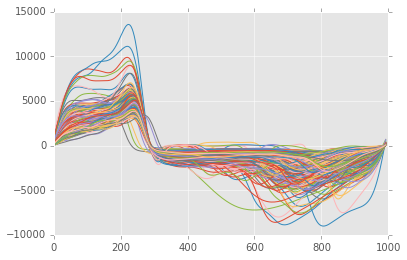

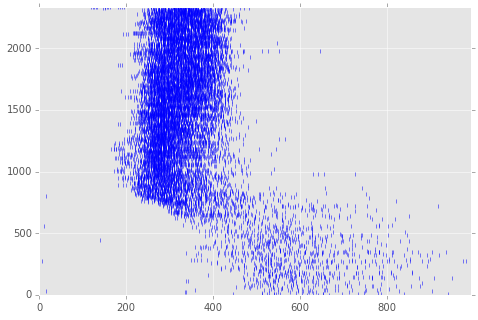

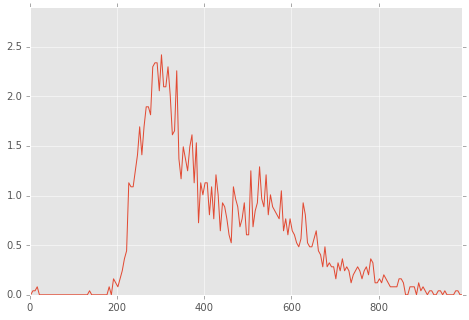

In [87]:
def get_warping_parameters(sniff):
    inh_len = np.max(sniff['inh_len'])
    exh_len = np.max(sniff['exh_len'])
    return inh_len, exh_len
                      
def resize_chunk(chunk, new_size):
    old_size = chunk.shape[0]
    x = np.linspace(0, 1, new_size)
    xp = np.linspace(0, 1, old_size)
    y = np.interp(x, xp, chunk)
    return y

warped = True
# make a baseline raster
all_spikes = all_records['responses']['ZKawakeM72_013_e_010']['all_spikes']
a = all_records['base_sniff']['ZKawakeM72_013_e']
#order by sniff lengths
all_sniffs = np.sort(a, order=['inh_len', 't_0']) 

#naturally, get the t0 as the 150 ms after the start of the sniff structure (inhale)
# nxt matrix with 1 where there is a spikes.
t_pre = 0
t_post = 300

n_sniffs = all_sniffs.shape[0]


if warped:
    inh_len, exh_len = get_warping_parameters(all_sniffs)
    t_2 = inh_len + exh_len
    t_1 = 0
else:
    t_2 = round(np.mean([sniff['flow'][sniff['t_zer'][0]:-1].shape[0] for sniff in all_sniffs]))
    t_1 = 0   
    
t_range = t_2-t_1
raster = np.zeros((n_sniffs,t_range))
flows  = np.zeros((t_range, n_sniffs))

t_post = t_range
i_f =0;
for flow in all_sniffs['flow']:
    t_zer = all_sniffs[i_f]['t_zer'][0]
    
    if warped:
        t_mid = all_sniffs[i_f]['t_zer_fit'][1]
        t_end = all_sniffs[i_f]['t_zer'][2]
        flows[0:inh_len,i_f] = resize_chunk(flow[t_zer:t_mid],inh_len)
        flows[inh_len:inh_len+exh_len,i_f] = resize_chunk(flow[t_mid:t_end],exh_len)
          
        #get absolute timestamps of spikes in the corresp. sniff segment
        t_inh = all_sniffs[i_f]['t_0']+t_zer
        t_exh_on = all_sniffs[i_f]['t_0']+t_mid
        t_exh_off = all_sniffs[i_f]['t_0']+t_end
        
        condition_inh = (all_spikes>t_inh+t_1) & (all_spikes<t_exh_on)
        spike_times = np.extract(condition_inh, all_spikes) - t_inh - t_1
        if spike_times.size>0:
            inh_spike_times = np.array(spike_times * inh_len/(t_mid-t_zer), dtype = int) 
            raster[i_f, inh_spike_times] = 1
        
        condition_exh = (all_spikes>t_exh_on) & (all_spikes<t_exh_off)
        spike_times = np.extract(condition_exh, all_spikes) - t_exh_on - t_1
        if spike_times.size>0:
            exh_spike_times = np.array(np.floor(spike_times * exh_len/(t_exh_off-t_exh_on) + inh_len-1),dtype = int)
            raster[i_f, exh_spike_times] = 1
        
    else:
        t_end = min(all_sniffs[i_f]['t_zer'][2]-all_sniffs[i_f]['t_zer'][0], t_2)

        flows[0:t_end,i_f] = flow[t_zer:t_zer+t_end]
        #get absolute timestamps of spikes in the corresp. sniff segment
        t_inh = all_sniffs[i_f]['t_0']+t_zer
        condition = (all_spikes>t_inh+t_1) & (all_spikes<t_inh+t_end)
        spike_times = np.extract(condition, all_spikes) - t_inh - t_1
        if spike_times.size>0:
            raster[i_f, spike_times] = 1
    i_f+=1

#complete periodically to fit in t_pre, t_post
if t_pre>0:
    raster = np.append(raster[:,-t_pre:-1], raster, axis = 1)

if t_post > t_2:
    raster = np.append(raster, raster[:,t_pre: t_post-t_2], axis = 1)
    
if t_post < t_2:
    raster = raster[:,0:t_pre+t_post]

plt.plot((flows[0:t_post,1000:2120]));
plot_raster(raster)
plot_raster(raster, bin_size=5)

In [61]:
print inh_spike_times
print spike_times
print t_mid
print t_zer
print inh_len
print (t_mid-t_zer)/inh_len
plt.plot(all_sniffs[i_f]['flow'])
print all_sniffs[i_f]['inh_len']
print t_inh

[ 74  76  78  80  82  85  88  97 118 121 129]
[150 154 158 162 166 171 177 196 237 243 260 295 317 318 319 349 356 359
 366 370 376 380 384 388 392 397 406 423 445 448 486]
437.171415773
150
143.294092466
2.00407016669


IndexError: index 2336 is out of bounds for axis 0 with size 2336

In [39]:
condition_inh = (all_spikes>t_inh+t_1) & (all_spikes<t_inh + all_sniffs[i_f]['inh_len'])
spike_times = np.extract(condition_inh, all_spikes)
print spike_times - t_inh

[161 164 168]


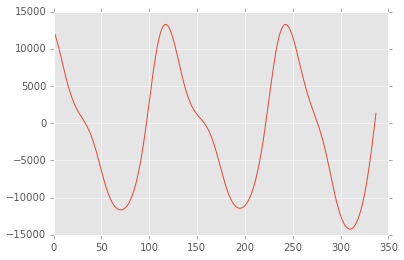

In [16]:
plt.plot(flow[t_zer+t_1:t_zer+t_2])

In [29]:
t_zer = all_sniffs[i_f]['t_zer'][0]
t_end = min(all_sniffs[i_f]['t_zer'][2], t_2)
print t_end

flows[0:t_end,i_f] = flow[t_zer:t_zer+t_end]
#get absolute timestamps of spikes in the corresp. sniff segment
t_inh = all_sniffs[i_f]['t_0']+t_zer
condition = (all_spikes>t_inh+t_1) & (all_spikes<t_inh+t_end)
spike_times = np.extract(condition, all_spikes) - t_inh - t_1
if spike_times.size>0:
    raster[spike_times,i_f] = 1
i_f+=1


270


ValueError: could not broadcast input array from shape (253) into shape (270)

In [35]:
flow[t_zer:t_zer+t_end].shape

(253,)

In [12]:
all_records['responses']['ZKawakeM72_013_f_010']['odor_resp']['spikes'].shape

(123, 2701)

In [37]:
min([(all_sniffs[x]['flow']).shape[0] for x in range(all_sniffs['flow'].shape[0])])

348

In [49]:
[x['t_zer'] for x in all_sniffs['t_zer']]

[array([150, 365, 797]),
 array([150, 353, 759]),
 array([150, 347, 753]),
 array([150, 341, 793]),
 array([150, 345, 637]),
 array([150, 286, 497]),
 array([150, 234, 506]),
 array([150, 251, 693]),
 array([150, 317, 730]),
 array([150, 325, 732]),
 array([150, 332, 714]),
 array([150, 328, 746]),
 array([150, 336, 756]),
 array([150, 340, 732]),
 array([150, 338, 778]),
 array([150, 339, 747]),
 array([150, 322, 751]),
 array([150, 343, 775]),
 array([150, 348, 756]),
 array([150, 360, 753]),
 array([150, 356, 792]),
 array([150, 217, 283]),
 array([133, 194, 285]),
 array([150, 231, 298]),
 array([148, 237, 300]),
 array([150, 236, 299]),
 array([149, 231, 289]),
 array([140, 192, 254]),
 array([114, 185, 249]),
 array([135, 217, 277]),
 array([142, 199, 261]),
 array([119, 185, 248]),
 array([129, 218, 276]),
 array([147, 209, 273]),
 array([126, 183, 248]),
 array([122, 245, 307]),
 array([150, 235, 300]),
 array([150, 224, 293]),
 array([143, 244, 302]),
 array([150, 238, 301]),


In [44]:
all_sniffs[0]['flow'][0:40]

array([-469.34870792, -473.90308697, -478.03242099, -481.70239113,
       -484.89439146, -487.6032223 , -489.8354455 , -491.60954761,
       -492.95532112, -493.91288103, -494.53337199, -494.88100965,
       -495.03514827, -495.08996476, -495.15076217, -495.33036388,
       -495.74626828, -496.51524302, -497.7457862 , -499.53211892,
       -501.95253176, -505.07066414, -508.93551336, -513.58048891,
       -519.0234273 , -525.26656604, -532.29720993, -540.09035273,
       -548.61250273, -557.827167  , -567.70263022, -578.22030036,
       -589.38116979, -601.20941317, -613.75411242, -627.08949292,
       -641.31177782, -656.53312655, -672.87606992, -690.46920166])